In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import matplotlib.pyplot as plt
import tools
from ConsumptionSavingModel import ConsumptionSavingModelClass
from consav import ModelClass, jit # baseline model class and jit
from consav import linear_interp # linear interpolation
from consav.grids import nonlinspace # grids
from consav.quadrature import log_normal_gauss_hermite # income shocks
from consav.misc import elapsed
from scipy import optimize

### Parameters

In [2]:
# Initialize parameter class
class par: pass

# Scalar parameters
par.alpha = 0.15 # Fraction of income earned as holiday pay
par.T = 30 # Number of periods
par.TR = 20 # Retirement age
par.TH = 10 # Holiday payout age
par.rho  = 2.0 # CRRA coeficient
par.beta = 0.96 # Discount factor
par.G = 1.02 # Permanten income growth factor
par.sigma_xi = 0.1 # Standard deviaton of transitory shock
par.sigma_psi = 0.1 # Standard deviaton of permanent shock
par.pi = 0.005 # Probability of low income shock
par.mu = 0.0 # Value of low income shock
par.R = 1.04 # Asset return factor
par.delta = 0.8 # Holiday pay return factor
par.m_max = 20.0 # Maximum point in grid for m
par.m_phi = 1.1 # Curvature of grid for m
par.h_max = 1 # Maximum point in grid for h
par.h_phi = 1.1 # Curvature of grid for h
par.Nxi = 8 # Number of quadrature points for xi
par.Npsi = 8 # Number of quadrature points for psi
par.Nm = 50 # Number of points in grid for m
par.Nh = 10 # Number of points in grid for h
par.sim_mini = 2.5 # Initial m in simulation
par.simN = 10_000 # Number of persons in simulation
par.seed = 2021 # Seed for random draws

# Life cycle
par.L = np.ones(par.T)
par.L[:par.TR] = np.linspace(1,1/(par.G),par.TR)
par.L[par.TR-1] = 0.90
par.L[par.TR-1:] = par.L[par.TR-1:]/par.G

### Model

In [3]:
def run_model(par):
    # 1. Prepare grids and allocate solution
    # Gauss Hermite
    psi, psi_w = log_normal_gauss_hermite(sigma=par.sigma_psi,n=par.Npsi)
    xi, xi_w = log_normal_gauss_hermite(sigma=par.sigma_xi,n=par.Nxi)

    # Add low income shock to xi
    if par.pi > 0:
        # Weights
        xi_w *= (1.0-par.pi)
        xi_w = np.insert(xi_w,0,par.pi)

        # Values
        xi = (xi-par.mu*par.pi)/(1.0-par.pi)
        xi = np.insert(xi,0,par.mu)

    # Vectorize tensor product of shocks and total weight
    psi_vec,xi_vec = np.meshgrid(psi,xi,indexing='ij')
    psi_w_vec,xi_w_vec = np.meshgrid(psi_w,xi_w,indexing='ij')

    par.psi_vec = psi_vec.ravel()
    par.xi_vec = xi_vec.ravel()
    par.w = xi_w_vec.ravel()*psi_w_vec.ravel()

    assert 1-np.sum(par.w) < 1e-8 # Check if weights sum to 1

    # Count number of shock nodes
    par.Nshocks = par.w.size

    # Create grids
    par.grid_m = nonlinspace(1e-6,par.m_max,par.Nm,par.m_phi)
    par.grid_h = nonlinspace(1e-6,par.h_max,par.Nh,par.h_phi)
     
    # Create solution and simulation
    class sol: pass
    class sim: pass

    # Allocate memory for solution
    sol_shape = (par.T,par.Nm,2,par.Nh) # (Time, cash-on-hand, holiday pay indicator, holiday pay amount)
    sol.c = np.zeros(sol_shape)
    sol.inv_v = np.zeros(sol_shape)

    # Allocate memory for simulation
    sim_shape = (par.simN,par.T)
    sim.m = np.zeros(sim_shape)
    sim.c = np.zeros(sim_shape)
    sim.a = np.zeros(sim_shape)
    sim.p = np.zeros(sim_shape)
    sim.y = np.zeros(sim_shape)
    sim.psi = np.zeros(sim_shape)
    sim.xi = np.zeros(sim_shape)
    sim.P = np.zeros(sim_shape)
    sim.Y = np.zeros(sim_shape)
    sim.M = np.zeros(sim_shape)
    sim.C = np.zeros(sim_shape)
    sim.A = np.zeros(sim_shape)
    sim.z = np.zeros((par.simN), dtype=int)
    sim.h = np.zeros(sim_shape)
    sim.H = np.zeros(sim_shape)
    
    # 2. Solve model by VFI
    def utility(c, par):
        return c**(1-par.rho)/(1-par.rho)    

    def marg_utility(c, par):
        return c**(-par.rho)      

    def inv_marg_utility(u, par):
        return u**(-1/par.rho)  

    def value_of_choice(c,t,m,h,z):
        # End-of-period assets
        a = m-c

        # Next-period cash-on-hand
        h_term = 0.0
        inv_v_plus = np.zeros(par.xi_vec.size)
        
        # Calculate inverse value-of-choice in next period
        still_working_next_period = t+1 <= par.TR-1
        if still_working_next_period:
            fac = par.G*par.L[t]*par.psi_vec
            w = par.w
            xi = par.xi_vec
            
            if z == 1:
                h_plus_vec = np.repeat(0.0, len(fac))
                m_plus = (par.R/fac)*a + xi
                inv_v_plus = tools.interp_2d_vec(par.grid_m, par.grid_h, sol.inv_v[t+1,:,z,:], m_plus, h_plus_vec)
            else:
                if t+1 <= par.TH-1:
                    h_plus_vec = np.repeat(0.0, len(fac))
                    m_plus = (par.R/fac)*a + xi
                    inv_v_plus = tools.interp_2d_vec(par.grid_m, par.grid_h, sol.inv_v[t+1,:,z,:], m_plus, h_plus_vec)
                else:
                    h_plus = (par.delta/fac)*h
                    h_plus_vec = h_plus
                    m_plus = (par.R/fac)*a + xi + h_plus
                    inv_v_plus = tools.interp_2d_vec(par.grid_m, par.grid_h, sol.inv_v[t+1,:,z,:], m_plus, h_plus_vec)

            
        else:
            fac = par.G*par.L[t]
            w = 1
            xi = 1
            
            h_plus = 0
            #if t+1 >= par.TR:
            #    h_plus = 0
            #else:
            #    h_plus = (par.delta/fac)*h
            
            if t+1 == par.TR and z == 0: h_term = h_plus
            m_plus = (par.R/fac)*a + xi + h_term
            inv_v_plus = tools.interp_2d(par.grid_m, par.grid_h, sol.inv_v[t+1,:,z,:], m_plus, h_plus)

        # Value-of-choice
        v_plus = 1/inv_v_plus
        total = utility(c,par) + par.beta*np.sum(w*fac**(1-par.rho)*v_plus)
        return -total

    # Last period (= consume all)
    for z in [0, 1]:
        for i_h in range(par.Nh):
            sol.c[-1,:,z,i_h] = par.grid_m
            for i,c in enumerate(sol.c[-1,:,z,i_h]):
                sol.inv_v[-1,i,z,i_h] = 1.0/utility(c,par)

        # Before last period
        for t in reversed(range(par.T-1)):
            for i_h, h in enumerate(par.grid_h):
                for i_m, m in enumerate(par.grid_m):
                    #if t >= par.TR and (z == 1 or i_h != 0): # After retirement, solution is independent of z and h [1]
                    #    sol.c[t,i_m,z,i_h] = sol.c[t,i_m,0,0]
                    #    sol.inv_v[t,i_m,z,i_h] = sol.inv_v[t,i_m,0,0]
                    #else:
                    #    if t >= par.TH and z == 1 and i_h != 0: # After holiday pay, solution is independent of h [2]
                    #        sol.c[t,i_m,z,i_h] = sol.c[t,i_m,z,0]
                    #        sol.inv_v[t,i_m,z,i_h] = sol.inv_v[t,i_m,z,0]
                    #    else:
                    obj = lambda c: value_of_choice(c,t,m,h,z)
                    result = optimize.minimize_scalar(obj,method='bounded',bounds=(0,m))

                    sol.c[t,i_m,z,i_h] = result.x
                    sol.inv_v[t,i_m,z,i_h] = -1.0/result.fun

    # 3. Simulate model
    # Set seed
    np.random.seed(par.seed)

    # Shocks
    _shocki = np.random.choice(par.Nshocks,size=(par.simN,par.T),p=par.w)
    sim.psi[:] = par.psi_vec[_shocki]
    sim.xi[:] = par.xi_vec[_shocki]

    # Initial values
    sim.m[:,0] = par.sim_mini 
    sim.p[:,0] = 0.0

    # loop over first households and then time
    for i in range(par.simN):
        h_term = 0.0
        for t in range(par.T):
            # Consumption
            sim.c[i,t] = tools.interp_2d(par.grid_m, par.grid_h, sol.c[t,:,sim.z[i],:], sim.m[i,t], sim.h[i,t])
            sim.a[i,t] = sim.m[i,t] - sim.c[i,t]
            
            if t < par.T-1:
#                 if t+2 < par.TH:
#                     sim.h[i,t+1] = 0
#                 elif t+2 == par.TH:
#                     sim.h[i][t+1] = par.alpha/(par.G*par.L[t]*sim.psi[i,t+1])
#                 elif t+2 > par.TH and t+1 <= par.TR and sim.z[i] == 0:
#                     sim.h[i][t+1] = par.delta*sim.h[i,t]/(par.G*par.L[t]*sim.psi[i,t+1]) 
#                 elif t+1 > par.TR or (t > par.TH and sim.z[i] == 1):
#                     sim.h[i][t+1] = 0

                if t+1 < par.TH:
                    sim.h[i,t] = 0
                elif t+1 == par.TH:
                    sim.h[i][t] = par.alpha/(par.G*par.L[t-1]*sim.psi[i,t])
                elif t+1 > par.TH and t+1 <= par.TR and sim.z[i] == 0:
                    sim.h[i][t] = (par.delta*sim.h[i,t-1])/(par.G*par.L[t-1]*sim.psi[i,t])
                elif t+1 > par.TR or (t > par.TH and sim.z[i] == 1):
                    sim.h[i][t] = 0

                if t+1 == par.TH:
                    inv_v0 = tools.interp_2d(par.grid_m, par.grid_h, sol.inv_v[t,:,0,:], sim.m[i,t], sim.h[i][t])
                    inv_v1 = tools.interp_2d(par.grid_m, par.grid_h, sol.inv_v[t,:,1,:], sim.m[i,t], sim.h[i][t])
                    if inv_v0 < inv_v1: # Early payment preferred
                        sim.z[i] = 0
                    else:
                        sim.z[i] = 1   
                
                if t+1 == par.TH and sim.z[i] == 1:
                    h_term = par.delta*sim.h[i,t]/(par.G*par.L[t]*sim.psi[i,t+1]) 
                elif t+1 == par.TR and sim.z[i] == 0:
                    h_term = par.delta*sim.h[i,t]/(par.G*par.L[t]) 
                else:
                    h_term = 0.0
                if t+1 == par.TR:
                    print(h_term)
                
                if t+1 > par.TR-1:
                    sim.m[i,t+1] = par.R*sim.a[i,t] / (par.G*par.L[t]) + 1 + h_term
                    sim.p[i,t+1] = np.log(par.G) + np.log(par.L[t]) + sim.p[i,t]
                    sim.y[i,t+1] = sim.p[i,t+1]
                else:
                    sim.m[i,t+1] = par.R*sim.a[i,t] / (par.G*par.L[t]*sim.psi[i,t+1]) + sim.xi[i,t+1] + h_term
                    sim.p[i,t+1] = np.log(par.G) + np.log(par.L[t]) + sim.p[i,t] + np.log(sim.psi[i,t+1])   
                    if sim.xi[i,t+1] > 0:
                        sim.y[i,t+1] = sim.p[i,t+1] + np.log(sim.xi[i,t+1])
                 
                
    # Renormalize
    sim.P[:,:] = np.exp(sim.p)
    sim.Y[:,:] = np.exp(sim.y)
    sim.M[:,:] = sim.m*sim.P
    sim.C[:,:] = sim.c*sim.P
    sim.A[:,:] = sim.a*sim.P
    sim.H[:,:] = sim.h*sim.P

    return sol, sim

### Run model

In [4]:
t0 = time.time()
sol, sim = run_model(par)
t1 = time.time()
print(f'Total runtime: {t1-t0:.2f} seconds')
print(f'Fraction getting early payments: {sim.z.mean():.3f}')

8337
0.014794817262661443
0.016592414872312392
0.013374016147249077
0.011983968615251951
0.018517006473276414
0.02866673267607726
0.014925298425701743
0.010779884018290076
0.009622286916825346
0.016656517432280478
0.010759120845786748
0.007702903058192616
0.01068564323569213
0.013374016147249082
0.010759120845786748
0.014925298425701743
0.014925298425701743
0.018552740972884757
0.014925298425701736
0.013348256407732732
0.020664835792137792
0.00694975296275929
0.013374016147249068
0.006239438234136234
0.01489655075593547
0.013399825598440097
0.016592414872312396
0.013348256407732732
0.00964085620385113
0.014925298425701736
0.016624435255499705
0.01489655075593547
0.012030267063833816
0.023017377267334292
0.010779884018290074
0.013348256407732725
0.016624435255499698
0.02066483579213779
0.0077558704739131784
0.008638819999845277
0.01200709552415087
0.015056930352121276
0.010779884018290074
0.010738397665302976
0.013374016147249077
0.018716364705219507
0.00694975296275929
0.01200709552415

### Checks

**Check 1:** Plot consumption for both consumers getting early and late payments

<ipython-input-6-f8663934e2db>:15: RuntimeWarning: Mean of empty slice.
  plt.plot(sim_var_early.mean(axis=0), label='early')
C:\Users\ems\Anaconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
Early: 0.000
Late:  1.000


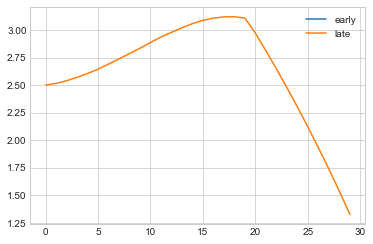

In [6]:
N_early = sum(sim.z)
N_late  = par.simN - N_early
sim_var_early = np.nan + np.zeros((N_early,par.T))
sim_var_late  = np.nan + np.zeros((N_late,par.T))
i_early = 0
i_late  = 0
for i,z_i in enumerate(sim.z):
    if z_i == 1:
        sim_var_early[i_early,:] = sim.M[i,:]
        i_early = i_early + 1
    else:
        sim_var_late[i_late,:] = sim.M[i,:]
        i_late = i_late + 1
        
plt.plot(sim_var_early.mean(axis=0), label='early')
plt.plot(sim_var_late.mean(axis=0),  label='late')
plt.legend()
print(f'Early: {N_early/(N_early+N_late):.3f}')
print(f'Late:  {N_late/(N_early+N_late):.3f}')

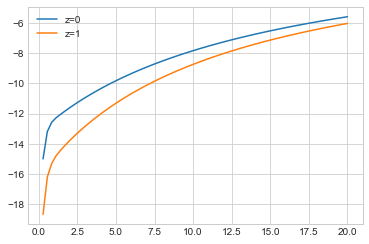

In [7]:
t = par.TH
grid_m = nonlinspace(1e-6,par.m_max,par.Nm,par.m_phi)
plt.plot(grid_m[1:], 1/sol.inv_v[t,1:,0,8],label='z=0')
plt.plot(grid_m[1:], 1/sol.inv_v[t,1:,1,8],label='z=1')
plt.legend()

In [39]:
sol.inv_v[t,1:,0,8]-sol.inv_v[t,1:,1,8]

array([-1.31838984e-16, -1.73472348e-16, -1.94289029e-16, -1.52655666e-16,
       -1.66533454e-16, -9.71445147e-17, -2.77555756e-17,  4.16333634e-17,
       -2.77555756e-17, -5.55111512e-17, -8.32667268e-17, -9.71445147e-17,
       -1.11022302e-16, -9.71445147e-17, -5.55111512e-17, -4.16333634e-17,
       -4.16333634e-17, -4.16333634e-17, -5.55111512e-17, -5.55111512e-17,
       -8.32667268e-17, -5.55111512e-17, -6.93889390e-17, -9.71445147e-17,
       -5.55111512e-17, -4.16333634e-17, -4.16333634e-17, -2.77555756e-17,
        0.00000000e+00,  6.93889390e-17,  6.93889390e-17,  2.77555756e-17,
        2.77555756e-17,  0.00000000e+00,  5.55111512e-17,  5.55111512e-17,
        0.00000000e+00,  2.77555756e-17, -2.77555756e-17, -2.77555756e-17,
       -5.55111512e-17, -1.11022302e-16, -1.38777878e-16, -1.94289029e-16,
       -2.77555756e-16, -3.88578059e-16, -5.82867088e-16, -7.77156117e-16,
       -1.05471187e-15])

In [ ]:
sim.h[0,par.TR]

In [ ]:
sim.m[0,par.TR]-sim.m[0,par.TR-1]

**Check 2:** Fraction of early payments as a function of $\delta$

In [ ]:
print(f'delta - mean of z')
for delta in [1.061, 1.062, 1.063]:
    par.delta = delta
    sol, sim = run_model(par)
    z_mean = sim.z.mean()
    print(f'{delta:.3f}   {z_mean:.3f}')
par.delta = 1.0625

**Check 3:** Fraction of early payments as a function of $\sigma_\xi=\sigma_\psi:=\sigma$

In [ ]:
print(f'sigma  - mean of z')
for sigma in [0.05, 0.10, 0.15]:
    par.sigma_xi  = sigma
    par.sigma_psi = sigma
    sol, sim = run_model(par)
    z_mean = sim.z.mean()
    print(f'{sigma:.2f}   {z_mean:.3f}')
par.sigma_xi  = 0.1
par.sigma_psi = 0.1

**Check 4:** Re-create standard buffer stock model (matches page 43 of 'ConsumptionSaving.pdf')

In [ ]:
par.alpha = 0
par.simN = 100_000
par.Nh = 2
par.T = 65
par.TR = 40
par.L = np.ones(par.T)
par.L[:par.TR] = np.linspace(1,1/(par.G),par.TR)
par.L[par.TR-1] = 0.90
par.L[par.TR-1:] = par.L[par.TR-1:]/par.G
sol, sim = run_model(par)

fig,ax = plt.subplots(2,2,figsize=(8,6),dpi=100)
ax[0,0].plot(range(25,90), sim.Y.mean(axis=0))
ax[0,1].plot(range(25,90), sim.M.mean(axis=0))
ax[1,0].plot(range(25,90), sim.C.mean(axis=0))
ax[1,1].plot(range(25,90), sim.A.mean(axis=0))
ax[0,0].set_title('Income, $Y_t$')
ax[0,1].set_title('Cash-on-hand, $M_t$')
ax[1,0].set_title('Consumption, $C_t$')
ax[1,1].set_title('End-of-period assets, $A_t$')
ax[0,0].grid(alpha=1/3)
ax[0,1].grid(alpha=1/3)
ax[1,0].grid(alpha=1/3)
ax[1,1].grid(alpha=1/3)
fig.subplots_adjust(hspace=1/3)

par.alpha = 0.15
par.simN = 10_000
par.T = 30
par.TR = 20
par.L = np.ones(par.T)
par.L[:par.TR] = np.linspace(1,1/(par.G),par.TR)
par.L[par.TR-1] = 0.90
par.L[par.TR-1:] = par.L[par.TR-1:]/par.G

**Check 5:** Fraction of early payments as a function of $\delta$ in de-complexified version of model

In [ ]:
# Turn of most complexifying aspects of model
par.delta = 1
par.sigma_xi = 0
par.sigma_psi = 0
par.mu = 1
par.pi = 0
par.R = 1
par.G = 1
par.beta = 1
par.L = np.ones((par.T))

# Check: Early payments as a function of delta
print(f'delta - mean of z')
for delta in [0.999, 1.001]:
    par.delta = delta
    sol, sim = run_model(par)
    z_mean = sim.z.mean()
    print(f'{delta:.3f}   {z_mean:.3f}')